# Welcome to Bank Dataset Analysis!

### Data Preprocessing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import torch

In [2]:
df = pd.read_csv("train.csv")
df.describe()

,id,age,balance,day,duration,campaign,pdays,previous,y
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,374999.500000,40.926395,1204.067397,16.117209,256.229144,2.577008,22.412733,0.298545,0.120651
std,216506.495284,10.098829,2836.096759,8.250832,272.555662,2.718514,77.319998,1.335926,0.325721
min,0.000000,18.000000,-8019.000000,1.000000,1.000000,1.000000,-1.000000,0.000000,0.000000
25%,187499.750000,33.000000,0.000000,9.000000,91.000000,1.000000,-1.000000,0.000000,0.000000
50%,374999.500000,39.000000,634.000000,17.000000,133.000000,2.000000,-1.000000,0.000000,0.000000
75%,562499.250000,48.000000,1390.000000,21.000000,361.000000,3.000000,-1.000000,0.000000,0.000000
max,749999.000000,95.000000,99717.000000,31.000000,4918.000000,63.000000,871.000000,200.000000,1.000000


In [3]:
df.isnull().sum() # no need to implement missing value imputation

id           0
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

#### Feature Engineering

In [4]:
for index in df.columns:
    print(f"{index}: {df[index].dtype}\n   {df[index].nunique()} unique values")

id: int64
   750000 unique values
age: int64
   78 unique values
job: object
   12 unique values
marital: object
   3 unique values
education: object
   4 unique values
default: object
   2 unique values
balance: int64
   8217 unique values
housing: object
   2 unique values
loan: object
   2 unique values


contact: object
   3 unique values
day: int64
   31 unique values
month: object
   12 unique values
duration: int64
   1760 unique values
campaign: int64
   52 unique values
pdays: int64
   596 unique values
previous: int64
   50 unique values
poutcome: object
   4 unique values
y: int64
   2 unique values


Dataset Content:
The dataset contains 45,211 entries with 17 attributes. The attributes represent client information and campaign details, and they include both categorical and numerical data.

age: Age of the client (numeric)

job: Type of job (categorical: "admin.", "blue-collar", "entrepreneur", etc.)

marital: Marital status (categorical: "married", "single", "divorced")

education: Level of education (categorical: "primary", "secondary", "tertiary", "unknown")

default: Has credit in default? (categorical: "yes", "no")

balance: Average yearly balance in euros (numeric)

housing: Has a housing loan? (categorical: "yes", "no")

loan: Has a personal loan? (categorical: "yes", "no")

contact: Type of communication contact (categorical: "unknown", "telephone", "cellular")

day: Last contact day of the month (numeric, 1-31)

month: Last contact month of the year (categorical: "jan", "feb", "mar", …, "dec")

duration: Last contact duration in seconds (numeric)

campaign: Number of contacts performed during this campaign (numeric)

pdays: Number of days since the client was last contacted from a previous campaign (numeric; -1 means the client was not previously contacted)

previous: Number of contacts performed before this campaign (numeric)

poutcome: Outcome of the previous marketing campaign (categorical: "unknown", "other", "failure", "success")

y: The target variable, whether the client subscribed to a term deposit (binary: "yes", "no")

In [5]:
# Create a new column 'education_unknown'
df['education_unknown'] = (df['education'] == 'unknown').astype(int)

# Define the mapping for ordinal encoding
education_map = {'primary': 1, 'secondary': 2, 'tertiary': 3, "unknown": np.nan}

# Apply the mapping to the 'education' column
# 'unknown' values will become NaN because they are not in the map
df['education'] = df['education'].map(education_map)

df.isnull().sum()

id                       0
age                      0
job                      0
marital                  0
education            21299
default                  0
balance                  0
housing                  0
loan                     0
contact                  0
day                      0
month                    0
duration                 0
campaign                 0
pdays                    0
previous                 0
poutcome                 0
y                        0
education_unknown        0
dtype: int64

In [6]:
df['pdays_contacted'] = (df['pdays'] > -1).astype(int)
df['pdays_contacted'].describe()

count    750000.000000
mean          0.103421
std           0.304509
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: pdays_contacted, dtype: float64

<Axes: >

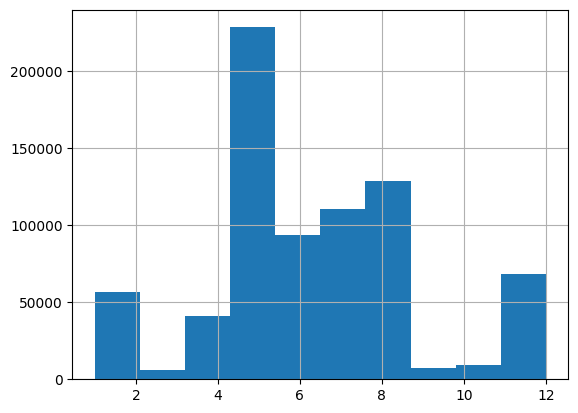

In [7]:
df['month'] = df['month'].map({'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
                               'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12})
df['month'].hist()

In [8]:
# encoding: basically one-hot encoding on df
df = pd.get_dummies(df, columns=['job', 'marital', 'contact', 'poutcome'], drop_first=True)
df

,id,age,education,default,balance,housing,loan,day,month,duration,...,job_technician,job_unemployed,job_unknown,marital_married,marital_single,contact_telephone,contact_unknown,poutcome_other,poutcome_success,poutcome_unknown
0,0,42,2.0,no,7,no,no,25,8,117,...,True,False,False,True,False,False,False,False,False,True
1,1,38,2.0,no,514,no,no,18,6,185,...,False,False,False,True,False,False,True,False,False,True
2,2,36,2.0,no,602,yes,no,14,5,111,...,False,False,False,True,False,False,True,False,False,True
3,3,27,2.0,no,34,yes,no,28,5,10,...,False,False,False,False,True,False,True,False,False,True
4,4,26,2.0,no,889,yes,no,3,2,902,...,True,False,False,True,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,749995,29,2.0,no,1282,no,yes,4,7,1006,...,False,False,False,False,True,False,True,False,False,True
749996,749996,69,3.0,no,631,no,no,19,8,87,...,False,False,False,False,False,False,False,False,False,True
749997,749997,50,2.0,no,217,yes,no,17,4,113,...,False,False,False,True,False,False,False,False,False,True
749998,749998,32,2.0,no,-274,no,no,26,8,108,...,True,False,False,True,False,False,False,False,False,True


In [9]:
df.isnull().sum()

id                       0
age                      0
education            21299
default                  0
balance                  0
housing                  0
loan                     0
day                      0
month                    0
duration                 0
campaign                 0
pdays                    0
previous                 0
y                        0
education_unknown        0
pdays_contacted          0
job_blue-collar          0
job_entrepreneur         0
job_housemaid            0
job_management           0
job_retired              0
job_self-employed        0
job_services             0
job_student              0
job_technician           0
job_unemployed           0
job_unknown              0
marital_married          0
marital_single           0
contact_telephone        0
contact_unknown          0
poutcome_other           0
poutcome_success         0
poutcome_unknown         0
dtype: int64

In [10]:
# Convert binary categorical variables to numeric before imputation
for col in ['default', 'housing', 'loan']:
	if col in df.columns:
		df[col] = df[col].map({'yes': 1, 'no': 0})

df

,id,age,education,default,balance,housing,loan,day,month,duration,...,job_technician,job_unemployed,job_unknown,marital_married,marital_single,contact_telephone,contact_unknown,poutcome_other,poutcome_success,poutcome_unknown
0,0,42,2.0,0,7,0,0,25,8,117,...,True,False,False,True,False,False,False,False,False,True
1,1,38,2.0,0,514,0,0,18,6,185,...,False,False,False,True,False,False,True,False,False,True
2,2,36,2.0,0,602,1,0,14,5,111,...,False,False,False,True,False,False,True,False,False,True
3,3,27,2.0,0,34,1,0,28,5,10,...,False,False,False,False,True,False,True,False,False,True
4,4,26,2.0,0,889,1,0,3,2,902,...,True,False,False,True,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,749995,29,2.0,0,1282,0,1,4,7,1006,...,False,False,False,False,True,False,True,False,False,True
749996,749996,69,3.0,0,631,0,0,19,8,87,...,False,False,False,False,False,False,False,False,False,True
749997,749997,50,2.0,0,217,1,0,17,4,113,...,False,False,False,True,False,False,False,False,False,True
749998,749998,32,2.0,0,-274,0,0,26,8,108,...,True,False,False,True,False,False,False,False,False,True


In [11]:
df_X, df_y = df.drop(columns=['y']), df['y']

In [12]:
from sklearn.impute import KNNImputer
# This is very dangerous since it might kill the terminal
# imputer = KNNImputer(n_neighbors=1)
# # impute the missing values
# df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
# Therefore we might adopt dimensional reduction first and then conduct imputation
from sklearn.decomposition import PCA

column = "education"
df1 = df_X.copy()
df2 = df_X.copy()
df2 = df2.drop(columns=[column])
df1 = df1[column]
pca = PCA(n_components=2)
df2_reduced = pca.fit_transform(df2)
df_reduced = pd.concat([pd.DataFrame(df2_reduced, columns=[f'PC{i+1}' for i in range(df2_reduced.shape[1])]), df1], axis=1)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.neighbors import NearestNeighbors

def knn_impute_df(df, k=5, n_neighbors_search=20, sample_for_neighbors=None, random_state=0):
    """
    资源友好 KNN Imputer（只对数值列生效）
    - df: pandas DataFrame（原表）
    - k: 用于加权平均的邻居数
    - n_neighbors_search: 最近邻搜索时的邻居数（>= k）
    - sample_for_neighbors: 若为 int，则随机抽样该数量行建立邻居索引以节省内存/时间
    """
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if len(num_cols) == 0:
        return df.copy()

    X_df = df[num_cols].astype(float).copy()
    X = X_df.to_numpy()
    mask = np.isnan(X)
    if not mask.any():
        return df.copy()

    # 临时均值填充用于构建邻居索引（避免带掩码的复杂距离计算）
    mean_imp = SimpleImputer(strategy='mean')
    X_fill = mean_imp.fit_transform(X)

    n_samples = X_fill.shape[0]
    # 确保搜索邻居数合法
    search_k = min(max(1, int(n_neighbors_search)), max(1, n_samples - 1))

    # 构建邻居索引（可选子采样）
    if isinstance(sample_for_neighbors, int) and 0 < sample_for_neighbors < n_samples:
        rng = np.random.RandomState(random_state)
        idx_sample = rng.choice(n_samples, size=sample_for_neighbors, replace=False)
        nbrs = NearestNeighbors(n_neighbors=search_k, n_jobs=-1).fit(X_fill[idx_sample])
        distances_sub, indices_sub = nbrs.kneighbors(X_fill, return_distance=True)
        # 将子索引映射回原索引
        indices = idx_sample[indices_sub]
        distances = distances_sub
    else:
        nbrs = NearestNeighbors(n_neighbors=search_k, n_jobs=-1).fit(X_fill)
        distances, indices = nbrs.kneighbors(X_fill, return_distance=True)

    X_imp = X.copy()
    # 按列填补缺失：使用邻居中实际有值的条目，按距离加权平均
    for j in range(X.shape[1]):
        missing_idx = np.where(mask[:, j])[0]
        if missing_idx.size == 0:
            continue
        col_vals = X[:, j]
        global_mean = np.nanmean(col_vals) if np.any(~np.isnan(col_vals)) else 0.0

        for i in missing_idx:
            neigh_idx = indices[i]
            neigh_dists = distances[i]
            valid_mask = ~np.isnan(col_vals[neigh_idx])
            if not np.any(valid_mask):
                X_imp[i, j] = global_mean
                continue
            valid_idxs = neigh_idx[valid_mask]
            valid_dists = neigh_dists[valid_mask]
            take = min(k, len(valid_idxs))
            vals = col_vals[valid_idxs[:take]].astype(float)
            d = valid_dists[:take].astype(float)
            weights = 1.0 / (d + 1e-8)
            X_imp[i, j] = np.sum(vals * weights) / np.sum(weights)

    result = df.copy()
    result[num_cols] = pd.DataFrame(X_imp, columns=num_cols, index=df.index)
    return result

In [13]:
imputer1 = KNNImputer(n_neighbors=1)
df_reduced_1 = imputer1.fit_transform(df_reduced)

: 

In [ ]:
df_imputed['education'].hist()